In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate, linalg, optimize, sparse
import statistics
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy.polynomial

Function definition

In [406]:
def closest(lst, K):
      
     lst = np.asarray(lst)
     idx = (np.abs(lst - K)).argmin()
     return lst[idx]
     
def closest_indx(lst, K):
      
     lst = np.asarray(lst)
     idx = (np.abs(lst - K)).argmin()
     return idx     

def counts_to_irradiance(flame_data, integration_time, k_filepath):
    
    k_data = np.loadtxt(k_filepath,skiprows=1) #
    irradiance = np.zeros(flame_data.shape)
    for i in range(len(irradiance[:,0])):
        irradiance[i,0] = flame_data[i,0]
        k_data_closest_index = np.where(k_data[:,0] == closest(k_data[:,0],flame_data[i,0]))[0]
        irradiance[i,1] = flame_data[i,1]*k_data[k_data_closest_index[0],1]/integration_time
        
    return irradiance

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def FD_dist(HWHM, center, wavelengths_to_evaluate, height = 1):
    return height*(1/(1+np.exp((center-wavelengths_to_evaluate)/HWHM)))

def c_matrix_generator(
input_spectra_fit,                  #This is the full spectra to generate the c_matrix
Red_sweep = True,               #If you want a red sweap, this should be True, if it is False then blue sweep is calculated.
Derivative = False,             #If true, the output gives also the derivative of each spectra with respect to the wavelength. 
Real_data = False,              #If true, we will need to pass the stepf_parameters matrix of the corresponding sweep.
stepf_parameters = 0,           #This is a numpy array containing the RScutwl, center, heigth, hwhm and constant of the stepfunction. (RScutwl is the reference cut wavelength that we have, but for the funtion of the stepfunction one takes the realcutwl which shold be the same for a RS but different for a BS)
c_matrix_min_wl = 360,          #The minimum wavelength of the c_matrix spectras (and also the resulting EQE). Redomended value 400 because it is the minimum of EQE measures
c_matrix_max_wl = 1000,         #The maximum wavelength of the c_matrix spectras (and also the resulting EQE). Recomended value 1000
c_matrix_res_wl = 1,            #The wavelength resolution of the c_matrix spectras (and also the resultin EQE)
c_matrix_min_cutwl = 400,       #The minimum cuting wavelength of the c_matrix spectras
c_matrix_max_cutwl = 810,       #The maximum cutting wavelength of the c_matrix spectras
c_matrix_res_cutwl = 10,        #The cutting wavelength spacing of the c_matrix spectras
c_matrix_stepf_HWHM = 5        #Define the value of this parameter
):
    if not Real_data:
        full_spectra_irradiance_fit = input_spectra_fit
        c_matrix_wl = np.arange(c_matrix_min_wl, c_matrix_max_wl, c_matrix_res_wl)      #These are the wavelengths wherein the c_matrix is evaluated horizontally (its spectras, and therefore the EQE)
        c_matrix_cutwl = np.arange(c_matrix_min_cutwl, c_matrix_max_cutwl, c_matrix_res_cutwl)  #There are the wavelengths wehrein the c_matrix is evaluated verticlaly (therefore, the different cutting wavelengths)
        c_matrix_RS_motor = np.zeros((len(c_matrix_cutwl), len(c_matrix_wl)))                   #We initialize the red sweep and blue sweep metor matrix
        c_matrix_BS_motor = np.zeros((len(c_matrix_cutwl), len(c_matrix_wl)))
        c_matrix_full_spectra = np.zeros((len(c_matrix_cutwl), len(c_matrix_wl)))               #And also the matrix containing all the full spectras for its multiplication with the motor matrix
        
        for i in range(len(c_matrix_full_spectra[:,0])):
            c_matrix_RS_motor[i,:] = FD_dist(c_matrix_stepf_HWHM, c_matrix_cutwl[i], c_matrix_wl)       #We define each row of the RS motor matrix with the FD stepfunction distribution
            c_matrix_BS_motor[i,:] = FD_dist(-c_matrix_stepf_HWHM, c_matrix_cutwl[i], c_matrix_wl)      #The same for the BS motor, in this case the FWHM has to be negative in order to have the blue part of the spectra
            
            if Derivative:                                                                          #If the derivative mode is activated
                c_matrix_RS_motor_derivative = np.zeros(c_matrix_RS_motor.shape)                    #we also need to initialize both RS and BS motor derivative matrices
                c_matrix_BS_motor_derivative = np.zeros(c_matrix_BS_motor.shape)
                for i in range(len(c_matrix_full_spectra[:,0])):
                    c_matrix_RS_motor_derivative [i,:] = FD_dist(c_matrix_stepf_HWHM, c_matrix_cutwl[i], c_matrix_wl)*(1-FD_dist(c_matrix_stepf_HWHM, c_matrix_cutwl[i], c_matrix_wl))  #And calculate them
                    c_matrix_BS_motor_derivative [i,:] = FD_dist(-c_matrix_stepf_HWHM, c_matrix_cutwl[i], c_matrix_wl)*(1-FD_dist(-c_matrix_stepf_HWHM, c_matrix_cutwl[i], c_matrix_wl))

        c_matrix_spectra_single = np.zeros(c_matrix_wl.shape)                                           #We also do the same with the c_matrix full spectra previously fited with splines
        for j in range(len(c_matrix_wl)):                                                           #But in this case we need to make the average around each c_matrix_wl
            actual_wl = c_matrix_wl[j]
            actual_spectra_average = statistics.mean(full_spectra_irradiance_fit(np.linspace(actual_wl-(c_matrix_res_wl/2),actual_wl+(c_matrix_res_wl/2), c_matrix_res_wl*10)))
            c_matrix_spectra_single[j] = 0.1*actual_spectra_average*c_matrix_res_wl*actual_wl/1240 #Here is the key part. This spectra is the one corresponding to the c_matrix with all the multiplication factors (ie, divided by energy of the photon and multiplyed by Q in order to get the current density)
            #The summ of the product between c_matrix_spectra_single and the EQE directly give the Jsc in mA/cm^2 (in thsi case for the full spectra)
        for i in range(len(c_matrix_full_spectra[:,0])):
            c_matrix_full_spectra [i,:] = c_matrix_spectra_single 

    if Real_data:
        full_spectra_irradiance_fit = input_spectra_fit
        c_matrix_wl = np.arange(c_matrix_min_wl, c_matrix_max_wl, c_matrix_res_wl)      #These are the wavelengths wherein the c_matrix is evaluated horizontally (its spectras, and therefore the EQE)
        c_matrix_cutwl = stepf_parameters[:,0]                              #There are the wavelengths wehrein the c_matrix is evaluated verticlaly (therefore, the different cutting wavelengths)
        c_matrix_motor = np.zeros((len(c_matrix_cutwl), len(c_matrix_wl)))                   #We initialize the red sweep and blue sweep metor matrix. In this case, because the positive/negative information is already presnt in the stepf matrix information, we will define a single motor matrix
        c_matrix_full_spectra = np.zeros((len(c_matrix_cutwl), len(c_matrix_wl)))               #And also the matrix containing all the full spectras for its multiplication with the motor matrix
        
        for i in range(len(c_matrix_full_spectra[:,0])):
            actual_RScutwl, actual_cutwl, actual_heigh, actual_hwhm, actual_constant = stepf_parameters[i,:]
            c_matrix_motor[i,:] = FD_dist(actual_hwhm, actual_cutwl, c_matrix_wl, height=actual_heigh) + actual_constant      #We define each row of the RS motor matrix with the FD stepfunction distribution
        
        if Derivative:                                                                          #If the derivative mode is activated
            c_matrix_motor_derivative = np.zeros(c_matrix_motor.shape)                    #we also need to initialize both RS and BS motor derivative matrices, which in this case are the same
            for i in range(len(c_matrix_full_spectra[:,0])):
                actual_RScutwl, actual_cutwl, actual_heigh, actual_hwhm, actual_constant = stepf_parameters[i,:]
                #print(actual_heigh)
                c_matrix_motor_derivative [i,:] = FD_dist(actual_hwhm, actual_cutwl, c_matrix_wl, height=1)*actual_heigh*(1-FD_dist(actual_hwhm, actual_cutwl, c_matrix_wl, height=1))  #And calculate them
                    

        c_matrix_BS_motor = c_matrix_motor          #Finally, when the motor matrix is constucted we define the BS and RS motor matrixes as this one, and what we choose initially will return the correct one. 
        c_matrix_RS_motor = c_matrix_motor
        c_matrix_BS_motor_derivative = c_matrix_motor_derivative
        c_matrix_RS_motor_derivative = c_matrix_motor_derivative

        c_matrix_spectra_single = np.zeros(c_matrix_wl.shape)                                           #We also do the same with the c_matrix full spectra previously fited with splines
        for j in range(len(c_matrix_wl)):                                                           #But in this case we need to make the average around each c_matrix_wl
            actual_wl = c_matrix_wl[j]
            actual_spectra_average = statistics.mean(full_spectra_irradiance_fit(np.linspace(actual_wl-(c_matrix_res_wl/2),actual_wl+(c_matrix_res_wl/2), c_matrix_res_wl*10)))
            c_matrix_spectra_single[j] = 0.1*actual_spectra_average*c_matrix_res_wl*actual_wl/1240 #Here is the key part. This spectra is the one corresponding to the c_matrix with all the multiplication factors (ie, divided by energy of the photon and multiplyed by Q in order to get the current density)
            #The summ of the product between c_matrix_spectra_single and the EQE directly give the Jsc in mA/cm^2 (in thsi case for the full spectra)
        for i in range(len(c_matrix_full_spectra[:,0])):
            c_matrix_full_spectra [i,:] = c_matrix_spectra_single 

    if not Derivative:    #If the derivative option is False, we just return the c_matrix
        if Red_sweep:
            c_matrix = c_matrix_RS_motor*c_matrix_full_spectra
        else:
            c_matrix = c_matrix_BS_motor*c_matrix_full_spectra

        return (c_matrix, c_matrix_wl, c_matrix_cutwl)
    
    if Derivative:      #If the derivative option is True, we calculate and return the c_matrix_derivative
        if Red_sweep:
            c_matrix = c_matrix_RS_motor*c_matrix_full_spectra
            c_matrix_derivative = c_matrix_RS_motor_derivative*c_matrix_full_spectra
        else:
            c_matrix = c_matrix_BS_motor*c_matrix_full_spectra
            c_matrix_derivative = c_matrix_BS_motor_derivative*c_matrix_full_spectra

        return (c_matrix, c_matrix_derivative, c_matrix_wl, c_matrix_cutwl)

#This function takes a c_matrix and makes the derivative of it in the vertical direction (along the cuting wavelength direction)
def c_matrix_vertical_derivative (
c_matrix,               #The c_matrix in question
c_matrix_cutwl,         #The cutting wavelength vector of the c_matrix
s_factor=0              #The factor that 
):
    c_matrix_vderivative = np.zeros(c_matrix.shape)
    for j in range(len(c_matrix[0,:])):
        actual_spl_fit = interpolate.UnivariateSpline(c_matrix_cutwl, c_matrix[:,j], s=s_factor)
        c_matrix_vderivative [:,j] = -actual_spl_fit.derivative(n=1)(c_matrix_cutwl)

    return c_matrix_vderivative
    
#This function takes a c_matrix and puts a certain noise to it. 
def c_matrix_noise_adder(
c_matrix_input,             #The c_matrix to put noise
percentage):                #The maximum percentage of this noise (the noise added at each poing will be in between +- this percentage to the magnitude at that point)
    c_matrix_input_noise = np.zeros(c_matrix_input.shape)
    for j in range(len(c_matrix_input[:,0])):
        for i in range(len(c_matrix_input[0,:])):
            c_matrix_input_noise[j,i] = c_matrix_input[j,i]*(100+percentage*np.random.random_sample())/100
    
    return c_matrix_input_noise

#This function is useful to plot all the spectras of a given c_matrix
def c_matrix_plotter(
c_matrix,                   #The c_matrix to plot
c_matrix_wl,                #The correponding c_matrix wavelength vector
legend = False,             #True for plotting the legend
concret_spectra = False,    #If you want to plot a concret spectra, just put here a number or a list of numbers
plotsize = (14,6)):        #True for plotting the legend
    if not concret_spectra:
        fig, ax = plt.subplots(figsize=plotsize)
        for i in range(len(c_matrix[:,0])):
            ax.plot(c_matrix_wl,c_matrix[i,:])
        plt.xlabel('Wavelength [nm]')
    if concret_spectra:
        fig, ax = plt.subplots(figsize=plotsize)
        for i in concret_spectra:
            ax.plot(c_matrix_wl,c_matrix[i,:], label=str(i))
        plt.xlabel('Wavelength [nm]')
        plt.legend()
#This function is used to calculate the Jsc
def Jsc_calculator(
full_spectra_irradiance,        #The full spectra irradiance imput
wl_resolution,                  #The wavelenegth resolution of the calculations
real_EQE_interp,                #The interpolation function of the measured EQE
noise_percentage = 0            #The noise percentage added to the Jsc curve
):
    calculated_Jsc_c_matrix_RS, calculated_Jsc_c_matrix_wl_RS, calculated_Jsc_c_matrix_cutwl_RS = c_matrix_generator(full_spectra_irradiance, Red_sweep=True, Derivative = False, c_matrix_res_wl=wl_resolution)
    calculated_Jsc_c_matrix_BS, calculated_Jsc_c_matrix_wl_BS, calculated_Jsc_c_matrix_cutwl_BS = c_matrix_generator(full_spectra_irradiance, Red_sweep=False, Derivative = False, c_matrix_res_wl=wl_resolution)
    calculated_Jsc_RS = np.zeros(len(calculated_Jsc_c_matrix_RS[:,0]))
    calculated_Jsc_BS = np.zeros(len(calculated_Jsc_c_matrix_BS[:,0]))
    for i in range(len(calculated_Jsc_c_matrix_RS[:,0])):
        calculated_Jsc_RS[i] = sum(calculated_Jsc_c_matrix_RS[i,:]*real_EQE_interp(calculated_Jsc_c_matrix_wl))
        calculated_Jsc_RS[i] = calculated_Jsc_RS[i]*(100+noise_percentage*np.random.random_sample())
        calculated_Jsc_BS[i] = sum(calculated_Jsc_c_matrix_BS[i,:]*real_EQE_interp(calculated_Jsc_c_matrix_wl))
        calculated_Jsc_BS[i] = calculated_Jsc_BS[i]*(100+noise_percentage*np.random.random_sample())
    return calculated_Jsc_RS, calculated_Jsc_BS, calculated_Jsc_c_matrix_cutwl_RS, calculated_Jsc_c_matrix_cutwl_BS 

Load spectra matrix (data and fit)

In [574]:
#spectras_folder = '30SetembreCalibrationSpectras' #Name of the folder with the blue and red calibration spectras
spectras_folder = '04OctubreCalibrationCutWL'
txt_filelist_RS = os.listdir(os.path.join(os.getcwd(), spectras_folder, 'Red Sweep Opening'))   #Remember to add 0 to the firsts file names!!
txt_filelist_BS = os.listdir(os.path.join(os.getcwd(), spectras_folder, 'Blue Sweep Opening')) #Remember to add 0 to the firsts file names!!
int_time = 0.001*0.6
k_filepath = 'flame_to_irradiance_calibrationfile.txt'
spectra_data_RS = None
spectra_data_BS = None
bg_spectra_RS = np.loadtxt(os.path.join(spectras_folder, 'Red Sweep Opening',txt_filelist_RS[0]), skiprows=1)
bg_spectra_BS = np.loadtxt(os.path.join(spectras_folder, 'Blue Sweep Opening', txt_filelist_BS[0]), skiprows=1)


for i in range(len(txt_filelist_RS)):
    actual_filepath = os.path.join(spectras_folder, 'Red Sweep Opening', txt_filelist_RS[i])
    load_spectra = np.loadtxt(actual_filepath, skiprows=1)
    actual_txt_spectra = np.zeros(load_spectra.shape)
    actual_txt_spectra [:,0] = load_spectra[:,0]
    actual_txt_spectra [:,1] = load_spectra[:,1] - 1*bg_spectra_RS[:,1]
    actual_irradiance_spectra = counts_to_irradiance(actual_txt_spectra,int_time,k_filepath)
    if i == 0:
        spectra_data_RS = actual_irradiance_spectra
    else:
        spectra_data_RS = np.dstack((spectra_data_RS, actual_irradiance_spectra))

for i in range(len(txt_filelist_BS)):
    load_spectra = np.loadtxt(os.path.join(spectras_folder, 'Blue Sweep Opening',txt_filelist_BS[i]), skiprows=1)
    actual_txt_spectra = np.zeros(load_spectra.shape)
    actual_txt_spectra [:,0] = load_spectra[:,0]
    actual_txt_spectra [:,1] = load_spectra[:,1] - 1*bg_spectra_BS[:,1]
    actual_irradiance_spectra = counts_to_irradiance(actual_txt_spectra,int_time,k_filepath)
    if i == 0:
        spectra_data_BS = actual_irradiance_spectra
    else:
        spectra_data_BS = np.dstack((spectra_data_BS, actual_irradiance_spectra))

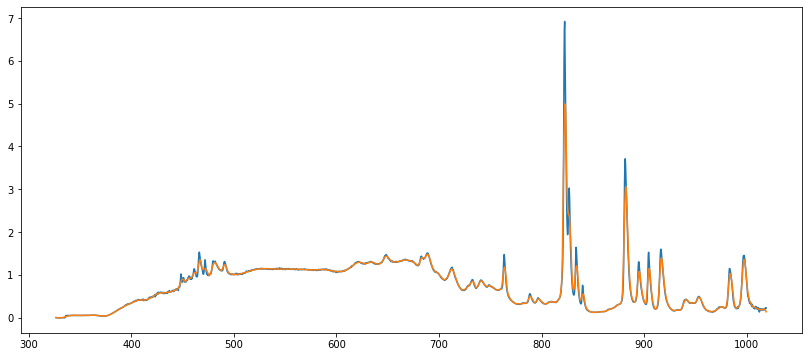

In [420]:
full_spectra_irradiance = spectra_data_BS[:,:,-1]
full_spectra_irradiance_fit = interpolate.UnivariateSpline(full_spectra_irradiance[:,0],smooth(full_spectra_irradiance[:,1],10), s=0.06)
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(full_spectra_irradiance[:,0], full_spectra_irradiance[:,1])
ax.plot(full_spectra_irradiance[:,0], full_spectra_irradiance_fit(full_spectra_irradiance[:,0]))


In [421]:
#We load the measurements:
BlueCell_Files_Directory = os.path.join(os.getcwd(), 'RainbowMeasures', 'PM6_IO-4Cl-BS')
BlueCell_Files_Directory_rainbow = os.path.join(
    BlueCell_Files_Directory, "TXT files"
)  # Define the directory where all the rainbow sweeps are saved (CellNumber)
BlueCell_Available_folders = os.listdir(BlueCell_Files_Directory_rainbow)
BlueCell_device_name = os.path.split(BlueCell_Files_Directory)[1]
BlueCells_names = []  # initialize the list of names
for folder in BlueCell_Available_folders:
    if not folder.endswith(
        ".txt"
    ):  # find for all the folders inside the specified path which corresponds to the measured cells without reading the calibration files (which are .txt files)
        cell_pathlist = os.listdir(
            os.path.join(BlueCell_Files_Directory_rainbow, folder)
        )  # enter to each foler corresponding to each measured cell
        for file in cell_pathlist:
            if file.endswith(
                ".txt"
            ):  # And store the data in the corresponding megaarray
                load_txt_filepath = os.path.join(
                    BlueCell_Files_Directory_rainbow, folder, file
                )
                actual_cell_data = np.loadtxt(load_txt_filepath, skiprows=1)
                BlueCells_names.append(folder)
                try:
                    BlueCell_megaarray
                except NameError:
                    BlueCell_megaarray = actual_cell_data
                else:
                    BlueCell_megaarray = np.dstack(
                        (BlueCell_megaarray, actual_cell_data)
                    )

RedCell_Files_Directory =  os.path.join(os.getcwd(), 'RainbowMeasures', 'PM6_IO-4Cl-RS')
RedCell_Files_Directory_rainbow = os.path.join(
    RedCell_Files_Directory, "TXT files"
)  # Define the directory where all the rainbow sweeps are saved (CellNumber)
RedCell_Available_folders = os.listdir(RedCell_Files_Directory_rainbow)
RedCell_device_name = os.path.split(RedCell_Files_Directory)[1]
RedCells_names = []
for folder in RedCell_Available_folders:
    if not folder.endswith(".txt"):

        cell_pathlist = os.listdir(
            os.path.join(RedCell_Files_Directory_rainbow, folder)
        )
        for file in cell_pathlist:
            if file.endswith(".txt"):
                load_txt_filepath = os.path.join(
                    RedCell_Files_Directory_rainbow, folder, file
                )
                actual_cell_data = np.loadtxt(load_txt_filepath, skiprows=1)
                RedCells_names.append(folder)
                try:
                    RedCell_megaarray
                except NameError:
                    RedCell_megaarray = actual_cell_data
                else:
                    RedCell_megaarray = np.dstack((RedCell_megaarray, actual_cell_data))

measure_divwl_RS = RedCell_megaarray[:,0,0]
measure_divwl_BS = BlueCell_megaarray[:,0,0]

Create the C matrix for red and blue sweep

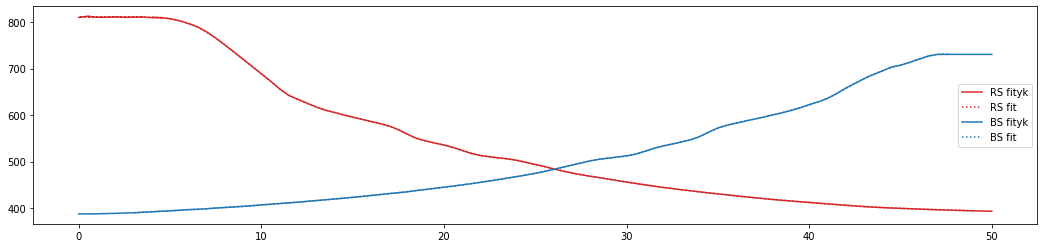

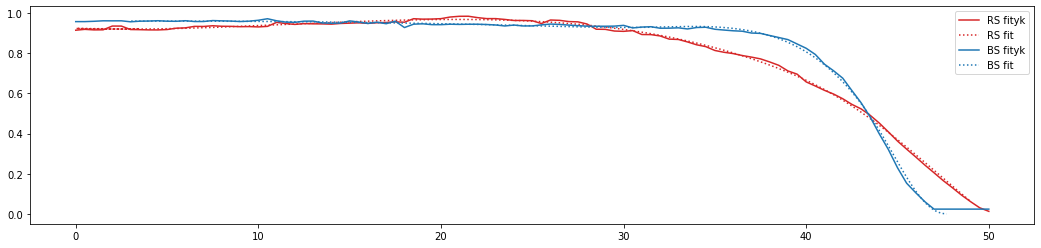

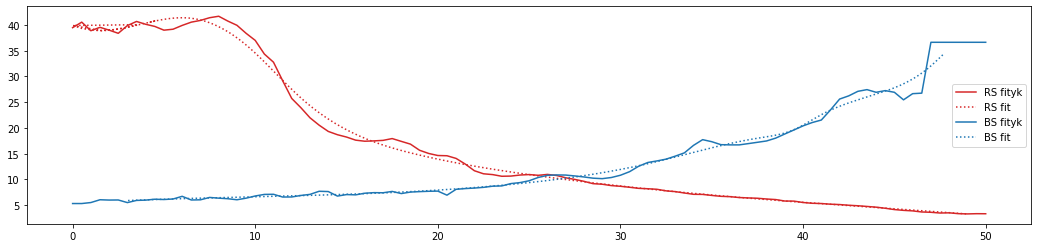

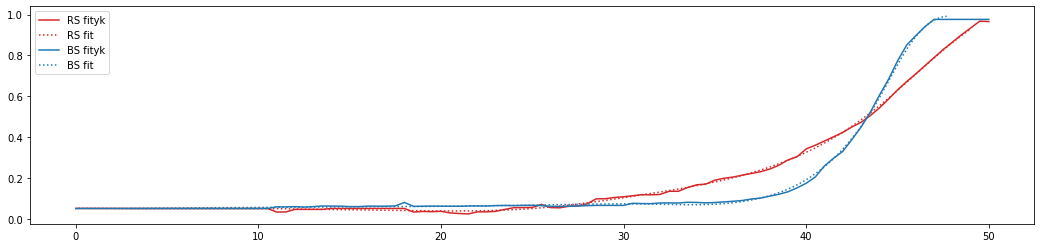

In [488]:
#This is a first tryal to fit the stepfunction fytik data with splines

fityk_RS = np.loadtxt(os.path.join(spectras_folder,'RedSweepOpening-fit_20211004.txt'),skiprows=1) #Red Motor position / Cut WL / Height / HWHM / constant BG
fityk_BS = np.loadtxt(os.path.join(spectras_folder,'BlueSweepOpening-fit_20211004.txt'),skiprows=1) #Blue Motor position / Cut WL / Height / HWHM / constant BG
divwl_motorpos = np.loadtxt(os.path.join(spectras_folder, 'Dividing Wavelength To Motor Position Calibration File_October2021.txt'), skiprows=1) #Cut wl reference (RS cutt WL) // RS (blue motor pos) // BS (red motor pos)
RS_stepf_parameters = np.zeros((len(divwl_motorpos[:,0]),5))    #Refence cut wl (RS cut wl) // Center // Heigh // hwhm // constant
BS_stepf_parameters = np.zeros((len(divwl_motorpos[:,0]),5))    #Refence cut wl (RS cut wl) // Center // Heigh // hwhm // constant
RS_stepf_parameters [:,0] = divwl_motorpos[:,0]
BS_stepf_parameters [:,0] = divwl_motorpos[:,0]

s_factor_stepf = [10,0.008,100,0.005]     #Center // Heigh // hwhm // constant . Tune there parameters to have the fit that you want!
for i in range(len(s_factor_stepf)):
    fig,ax = plt.subplots(figsize=(18,4))           #Initialize the plot
    ax.plot(fityk_RS[:,0], fityk_RS[:,i+1], label='RS fityk', color = 'tab:red')                                                #Plot the RS corresponding parameter as a function of the motor position
    RS_stepf_fit = interpolate.UnivariateSpline(np.flip(fityk_RS[:,0]), np.flip(fityk_RS[:,i+1]), s=s_factor_stepf[i])          #we make the spline fit to the parameter
    ax.plot(divwl_motorpos[:,1], RS_stepf_fit(divwl_motorpos[:,1]), label = 'RS fit', color = 'tab:red', linestyle='dotted')    #and plot the spline with the motor position resolution of the divwl_motorpos matrix
    RS_stepf_parameters [:,i+1] = RS_stepf_fit(divwl_motorpos[:,1])                                                             #and finally save it to the RS_stepf_parameters

    ax.plot(fityk_BS[:,0], fityk_BS[:,i+1], label='BS fityk', color = 'tab:blue')                                               #Plot the BS corresponding parameter as a function of the motor position
    BS_stepf_fit = interpolate.UnivariateSpline(fityk_BS[:,0], fityk_BS[:,i+1], s=s_factor_stepf[i])                            #we make the spline fit to the parameter
    ax.plot(divwl_motorpos[:,2], BS_stepf_fit(divwl_motorpos[:,2]), label='BS fit',color = 'tab:blue',  linestyle='dotted')     #and plot the spline with the motor position resolution of the divwl_motorpos matrix
    BS_stepf_parameters [:,i+1] = BS_stepf_fit(divwl_motorpos[:,2])                                                             #and finally save it to the RS_stepf_parameters
    if i == 2:      #In the case of the BS, the HWHM has to be negative to have the stepf to the other side
        BS_stepf_parameters[:,i] = -BS_stepf_parameters[:,i]
    plt.legend()

#Finally we create the short stepf parameter matrices which are the ones corresponding to the cutting wavelengths. 
RS_stepf_parameters_short = np.zeros((len(measure_divwl_RS), len(RS_stepf_parameters[0,:])))       #We initiallize the corresponding arrays
BS_stepf_parameters_short = np.zeros((len(measure_divwl_BS), len(BS_stepf_parameters[0,:])))

for i in range(len(measure_divwl_RS)):
    RS_stepf_index = closest_indx(RS_stepf_parameters[:,0], measure_divwl_RS[i])           #We find the index of the cutting wavelength of the stef_parameter matrix closer to the measure_divwl
    RS_stepf_parameters_short[i,:] = RS_stepf_parameters[RS_stepf_index,:]              #And assign all the line to the corresponding short matrix

for i in range (len(measure_divwl_BS)):
    BS_stepf_index = closest_indx(BS_stepf_parameters[:,0], measure_divwl_BS[i])           #The same for the blue sweep
    BS_stepf_parameters_short[i,:] = BS_stepf_parameters[BS_stepf_index]

#Here we tune some of the parameters of the stepf matrices, to try things. For example, first set the heigh to 1 for all the stepfs, and the constant to 0. 
#BS_stepf_parameters_short[:,2] = 1          #Set all the heights to 1
#BS_stepf_parameters_short[:,-1] = 0         #Set all the constants to 0
#RS_stepf_parameters_short[:,2] = 1          #Set all the heights to 1
#RS_stepf_parameters_short[:,-1] = 0         #Set all the constants to 0


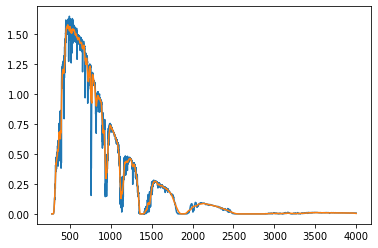

In [489]:
#Load the NREL Am1.5G spectra as the imput spectra

NREL_spectras = np.loadtxt('NREL_oficial_spectras.txt', skiprows=2)
AM15G_spectra = NREL_spectras[:,(0,2)]
fig, ax =plt.subplots()
ax.plot(AM15G_spectra[:,0], AM15G_spectra[:,1])
AM15G_spectra_fit = interpolate.interp1d(AM15G_spectra[:,0], smooth(AM15G_spectra[:,1],20))
ax.plot(AM15G_spectra[:,0], AM15G_spectra_fit(AM15G_spectra[:,0]))

In [559]:
CUTWL_RES = 10
HWHM = CUTWL_RES

RS_stepf_parameters_short[:,3] = HWHM
RS_stepf_parameters_short[:,4] = 0
RS_stepf_parameters_short[:,2] = 1
BS_stepf_parameters_short[:,3] = -HWHM
BS_stepf_parameters_short[:,4] = 0
BS_stepf_parameters_short[:,2] = 1

c_matrix_RS, c_matrix_derivative_RS, c_matrix_wl_RS, c_matrix_cutwl_RS = c_matrix_generator(AM15G_spectra_fit, Real_data=True, stepf_parameters=RS_stepf_parameters_short, Red_sweep=True, Derivative= True, c_matrix_res_cutwl=CUTWL_RES, c_matrix_stepf_HWHM=HWHM)
c_matrix_BS, c_matrix_derivative_BS, c_matrix_wl_BS, c_matrix_cutwl_BS = c_matrix_generator(AM15G_spectra_fit, Real_data=True, stepf_parameters=BS_stepf_parameters_short, Red_sweep=False, Derivative= True, c_matrix_res_cutwl=CUTWL_RES, c_matrix_stepf_HWHM=HWHM)

In [560]:
for i in range(len(c_matrix_derivative_RS[:,0])):
    c_matrix_derivative_RS[i,:] = -c_matrix_derivative_RS[i,:]*BS_stepf_parameters_short[-i,2]/2/BS_stepf_parameters_short[-i,3]

for i in range(len(c_matrix_derivative_BS[:,0])):
    c_matrix_derivative_BS[i,:] = -c_matrix_derivative_BS[i,:]/BS_stepf_parameters_short[i,3]

(42, 640)


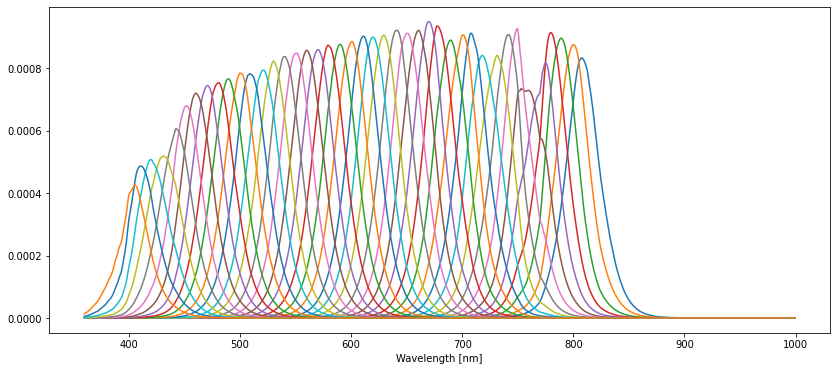

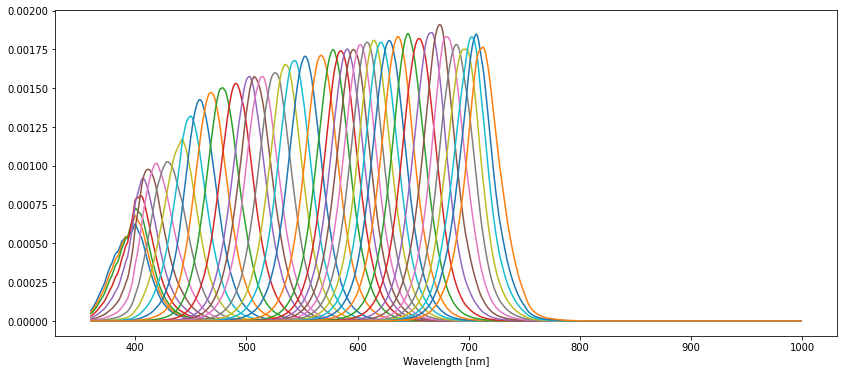

In [561]:
c_matrix_plotter(c_matrix_derivative_RS, c_matrix_wl_RS)
c_matrix_plotter(c_matrix_derivative_BS, c_matrix_wl_BS)
print(c_matrix_derivative_RS.shape)


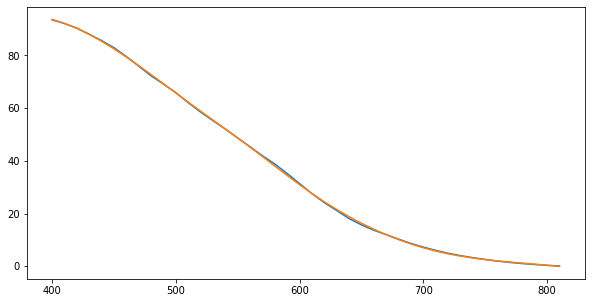

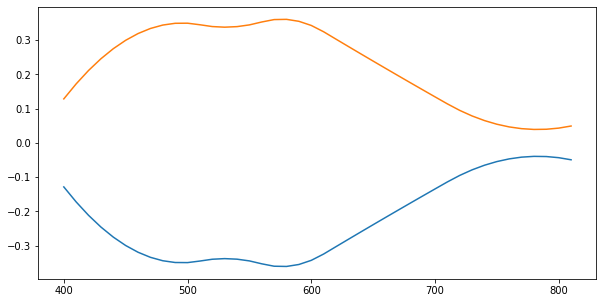

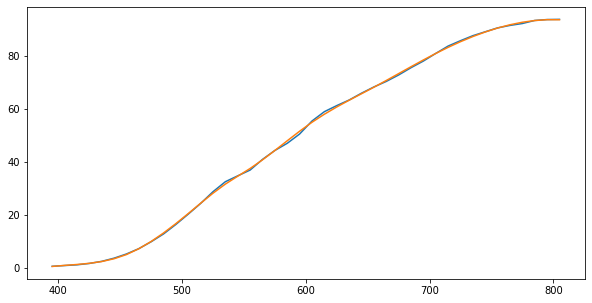

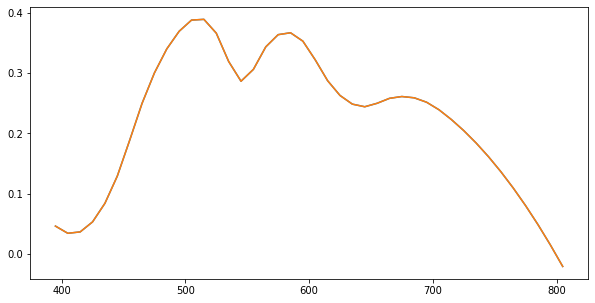

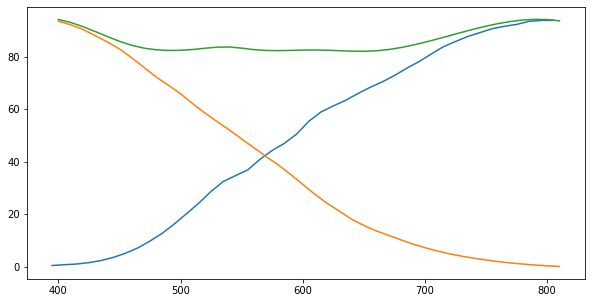

In [572]:
t = 8
measure_Jsc_RS = -RedCell_megaarray[:,2,t]
measure_Jsc_BS = -BlueCell_megaarray[:,2,t]

measure_Jsc_RS_fit=interpolate.UnivariateSpline(np.flip(measure_divwl_RS), np.flip(measure_Jsc_RS), s=4)
fig, ax =plt.subplots(figsize=(10,5))
ax.plot(measure_divwl_RS, measure_Jsc_RS)
ax.plot(measure_divwl_RS, measure_Jsc_RS_fit(measure_divwl_RS))
fig, ax =plt.subplots(figsize=(10,5))
ax.plot(measure_divwl_RS, measure_Jsc_RS_fit.derivative(n=1)(measure_divwl_RS))
measure_Jsc_RS_fit_at_divwl = measure_Jsc_RS_fit(measure_divwl_RS)
measure_Jsc_RS_derivative = measure_Jsc_RS_fit.derivative(n=1)(measure_divwl_RS)
ax.plot(measure_divwl_RS, -measure_Jsc_RS_derivative)

measure_Jsc_BS_fit=interpolate.UnivariateSpline(measure_divwl_BS, measure_Jsc_BS, s=7)
fig, ax =plt.subplots(figsize=(10,5))
ax.plot(measure_divwl_BS, measure_Jsc_BS)
ax.plot(measure_divwl_BS, measure_Jsc_BS_fit(measure_divwl_BS))
fig, ax =plt.subplots(figsize=(10,5))
ax.plot(measure_divwl_BS, measure_Jsc_BS_fit.derivative(n=1)(measure_divwl_BS))
measure_Jsc_BS_fit_at_divwl = measure_Jsc_BS_fit(measure_divwl_BS)
measure_Jsc_BS_derivative = measure_Jsc_BS_fit.derivative(n=1)(measure_divwl_BS)
ax.plot(measure_divwl_BS, measure_Jsc_BS_derivative)

fig, ax =plt.subplots(figsize=(10,5))
ax.plot(measure_divwl_BS, measure_Jsc_BS, label = 'BS')
ax.plot(measure_divwl_RS, measure_Jsc_RS, label = 'RS')
ax.plot(measure_divwl_RS, measure_Jsc_RS_fit(measure_divwl_RS)+np.flip(measure_Jsc_BS_fit(measure_divwl_BS)))

In [552]:
c_matrix_derivative = np.vstack((c_matrix_derivative_RS, c_matrix_derivative_BS))
measure_Jsc_derivative = np.hstack((measure_Jsc_RS_derivative, measure_Jsc_BS_derivative))
c_matrix_wl = c_matrix_wl_BS
print(c_matrix_derivative.shape, measure_Jsc_derivative.shape)

(84, 640) (84,)


[ 4.06081247e-05 -1.82035058e-04  4.64933009e-04 -7.27585576e-04
  6.67183273e-04 -2.56794586e-04 -1.93357116e-04  4.00226855e-04
 -3.25365454e-04  8.52307594e-05  1.84898040e-04 -3.79658015e-04
  3.74887868e-04 -1.01751625e-04 -4.30610755e-04  1.04793375e-03
 -1.32851369e-03  1.10563845e-03 -7.40362275e-04  2.13045719e-04
  4.63887068e-04 -1.06956938e-03  1.46993860e-03 -1.42947769e-03
  9.33245626e-04 -1.29448188e-04 -5.62680514e-04  8.27707765e-04
 -7.03575248e-04  3.48513693e-04 -7.99879281e-05  8.56184869e-05
 -2.78190621e-04  4.83590554e-04 -5.23620803e-04  2.30929355e-04
  6.25969774e-04 -2.01500247e-03  3.53946956e-03 -3.88531118e-03
  2.75396931e-03 -1.08354659e-03]
[-0.05259206 -0.04564761 -0.041645   -0.04058423 -0.04246529 -0.0472882
 -0.05505294 -0.06575953 -0.07940795 -0.09599821 -0.1155303  -0.13675496
 -0.15842291 -0.18053414 -0.20308865 -0.22608646 -0.24952754 -0.27341191
 -0.29773957 -0.32251051 -0.34772473 -0.36894525 -0.38173509 -0.38609423
 -0.38202268 -0.36952044 

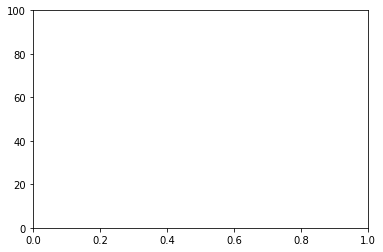

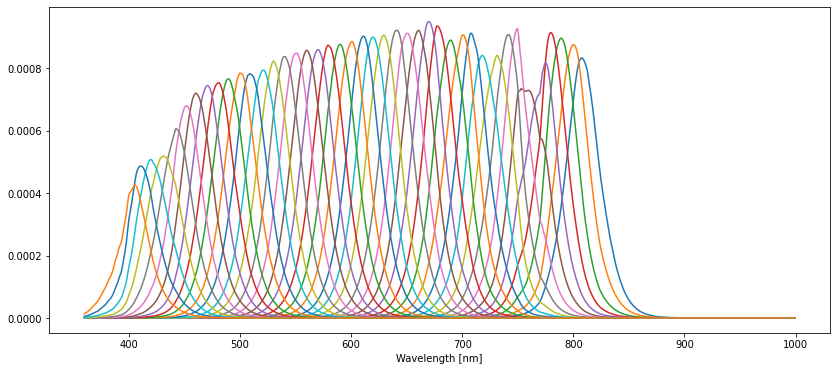

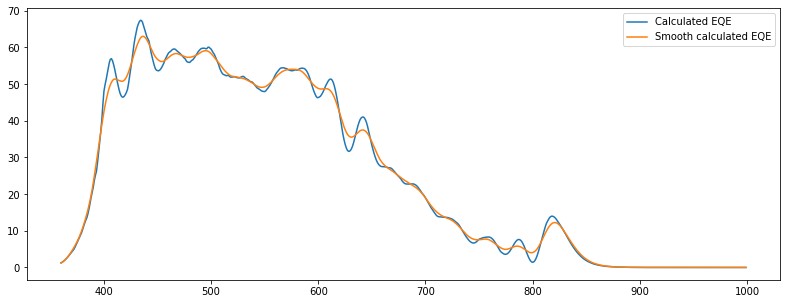

In [586]:
plt.ylim(0,100)
#c_matrix_vderivative = -1*c_matrix_vertical_derivative(c_matrix,axis=0, measure_divwl,s_factor=0)

#c_matrix_derivative[-5:,:] = c_matrix_derivative[-5:,:] * 2
#c_matrix_derivative[:3,:] = c_matrix_derivative[:3,:] * 2
c_matrix_plotter(c_matrix_derivative_RS, c_matrix_wl)#, concret_spectra=[0])

EQE_linearsolution_all = optimize.lsq_linear(-c_matrix_derivative_RS,5*measure_Jsc_RS_derivative, bounds=(0,100), lsq_solver='lsmr', tol=0.0001, method='trf', max_iter=2000000)
#EQE_linearsolution, rnorm = optimize.nnls(c_matrix_derivative,10*np.flip(measure_Jsc_derivative), maxiter=2000000)
print(EQE_linearsolution_all.fun)
print(measure_Jsc_derivative)
EQE_linearsolution = EQE_linearsolution_all.x
#print(EQE_linearsolution_all.success)
fig,ax = plt.subplots(figsize=(13.5,5))
ax.plot(c_matrix_wl, EQE_linearsolution, label='Calculated EQE')

ax.plot(c_matrix_wl, smooth(EQE_linearsolution,20), label='Smooth calculated EQE')
#ax.plot(c_matrix_wl, interpolate.UnivariateSpline(c_matrix_wl, smooth(EQE_linearsolution,40),s=40)(c_matrix_wl))
#ax.plot(real_EQE[:,0], real_EQE[:,1], label='Real EQE')
plt.legend()
#plt.ylim(0,100)

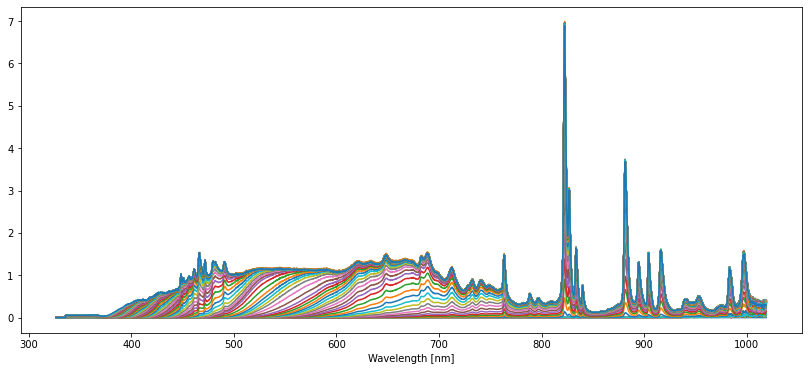

In [585]:
BS_spectras = np.transpose(spectra_data_RS[:,1,:])
BS_spectras_wl = spectra_data_RS[:,0,0]
c_matrix_plotter(BS_spectras, BS_spectras_wl)